#   IAU Zadanie - Aktivita na cviceni

### Autori: Peter Brandajsky - 50%, Frederik Duvač - 50%

#### Import vsetkych potrebnych kniznic

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Pre prácu s obrazkami
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/faces-age-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/faces-age-detection-dataset/versions/2


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 15 14:04:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              49W / 400W |   8673MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## 4.1.A

### EDA

#### Základne informácie o datasete

In [ ]:
# Locate the train.csv file
csv_path = os.path.join(path, "faces/train.csv")
images_path = os.path.join(path, "faces/Train")

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)

# Display dataset information
print("Dataset info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
dtypes: object(2)
memory usage: 311.2+ KB
None

First 5 rows:
          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


#### Analýza distribúcie tried


Class distribution:
Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


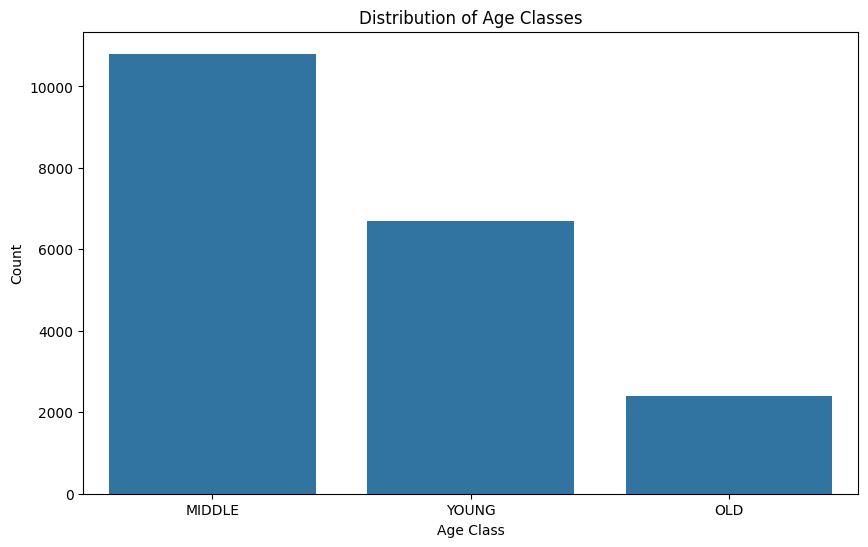

In [ ]:
class_distribution = df['Class'].value_counts()
print("\nClass distribution:")
print(class_distribution)

# Vizualizácia distribúcie
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Distribution of Age Classes')
plt.ylabel('Count')
plt.xlabel('Age Class')
plt.show()

Vzhľadom na to, že máme nepomer tried, tak nastavíme pri trénovaní rozdielne váhy pre triedy aby sme optimalizovali učenie modelov.

#### Analýza obrazkov

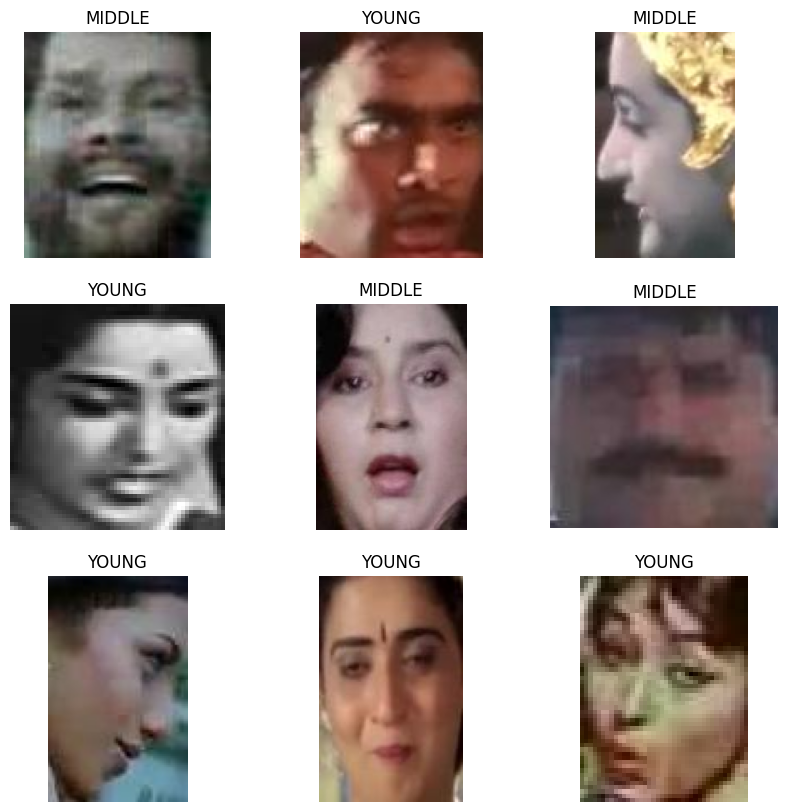

In [ ]:
# Zobrazenie niekoľkých obrázkov
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(images_path, df['ID'][i])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
    plt.title(df['Class'][i])
    plt.axis('off')
plt.show()

#### Ako mozme vidiet, obrazky nie su rovnakej velkosti a nemaju rovnaku kvalitu, tak musime spravit nejaky preproccesing

### Preprocessing

#### V tomto kode
- Štandardizujeme veľkosť všetkých obrázkov
- Normalizujeme hodnoty pixelov do rozsahu 0-1
- Rozdelíme dataset na trénovaciu, validačnú a testovaciu časť
- Vytvoríme efektívny generátor dát pre trénovanie

In [ ]:
# Definujeme konštanty pre preprocessing
TARGET_SIZE = (224, 224)  # štandardná veľkosť pre mnohé CNN architektúry
BATCH_SIZE = 64  # veľkosť dávok pre tréning

# Enkódovanie labelov
label_encoder = LabelEncoder()
df['Class_encoded'] = label_encoder.fit_transform(df['Class'])

df.head(10)

,ID,Class,Class_encoded
0,377.jpg,MIDDLE,0
1,17814.jpg,YOUNG,2
2,21283.jpg,MIDDLE,0
3,16496.jpg,YOUNG,2
4,4487.jpg,MIDDLE,0
5,6283.jpg,MIDDLE,0
6,23495.jpg,YOUNG,2
7,7100.jpg,YOUNG,2
8,6028.jpg,YOUNG,2
9,22617.jpg,OLD,1


In [ ]:
# Rozdelenie na tréning, validačnú a testovaciu množinu
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))


Training set size: 15924
Validation set size: 1991
Test set size: 1991


Found 15924 validated image filenames belonging to 3 classes.
Found 1991 validated image filenames belonging to 3 classes.
Found 1991 validated image filenames belonging to 3 classes.


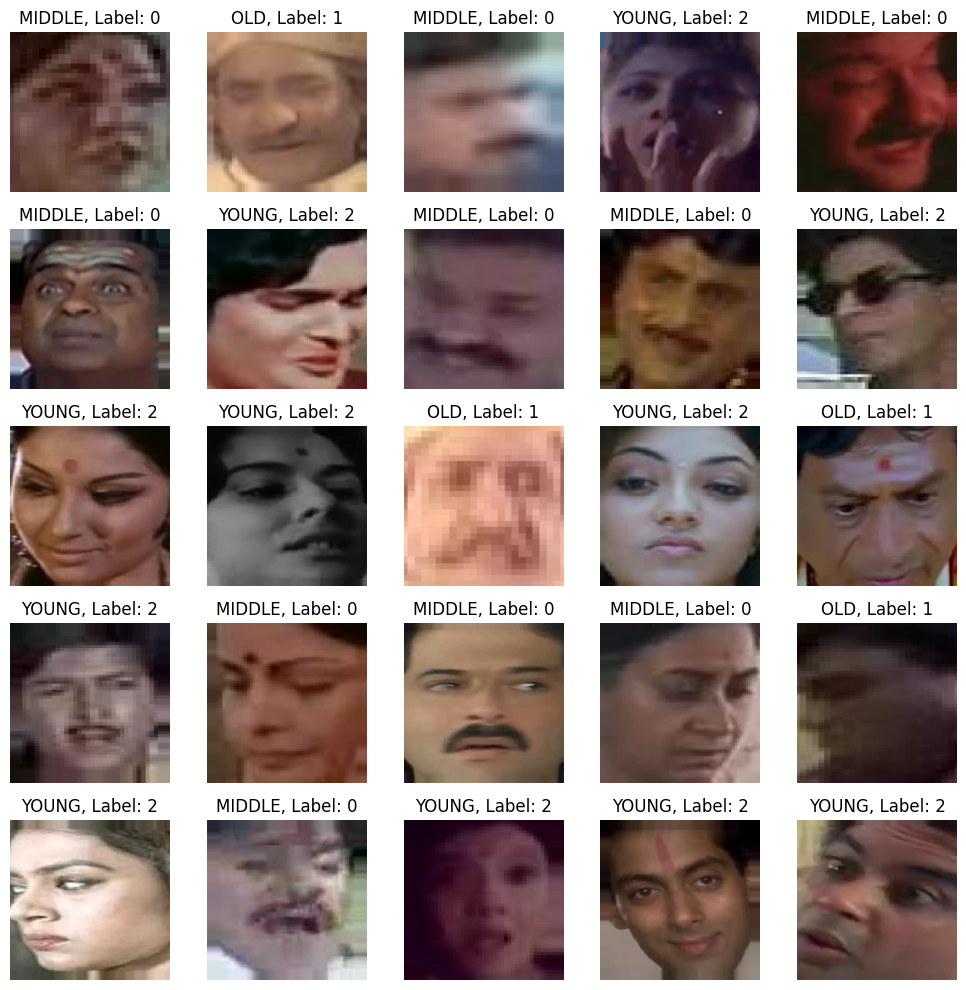

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definícia augmentačného generátora pre tréning
train_augmentation = ImageDataGenerator(
    rescale=1.0 / 255,      # Normalizácia pixelov na rozsah 0-1
    zoom_range=0.2,         # Náhodné priblíženie/oddialenie
    shear_range=0.2,        # Náklon obrázkov
    horizontal_flip=True,   # Horizontálne zrkadlenie s pravdepodobnosťou 50%
)

# Generátor len pre normalizáciu na validačné a testovacie dáta
val_test_normalization = ImageDataGenerator(rescale=1.0 / 255)

# Tréningový generátor
train_gen = train_augmentation.flow_from_dataframe(
    dataframe=train_df,
    directory=images_path,
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,  # Rozmery obrázkov
    batch_size=BATCH_SIZE,
    class_mode="categorical",  # Kategórie (jedno-hot encoding)
    shuffle=True  # Náhodné miešanie dávok
)

# Validačný generátor (len normalizácia)
val_gen = val_test_normalization.flow_from_dataframe(
    dataframe=val_df,
    directory=images_path,
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

# Testovací generátor (len normalizácia, nemieša poradie)
test_gen = val_test_normalization.flow_from_dataframe(
    dataframe=test_df,
    directory=images_path,
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Zachovanie poradia pre presné vyhodnotenie
)

augmented_images, labels = next(train_gen)  # Získa jednu dávku obrázkov z generátora

# Zobrazenie 5x5 => 25 augmentovaných obrázkov
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(label_encoder.inverse_transform([np.argmax(labels[i])])[0] + ", Label: " + str(np.argmax(labels[i])))
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4.1.B

### Pre Age Detection dataset plánujeme implementovať a porovnať tri rôzne prístupy založené na konvolučných neurónových sieťach (CNN). Konkrétne využijeme vlastnú CNN architektúru, Xception a ResNet50. Zdôvodnenie výberu:

#### Charakter dát:

- Pracujeme s obrázkami tvárí
- Máme 3 triedy (YOUNG, MIDDLE, OLD)
- Dataset obsahuje veľké množstvo vzoriek (19906 obrázkov)
- Obrázky majú rôznu kvalitu a veľkosť

#### Prečo CNN?

- CNN sú špecializované na spracovanie obrazových dát
- Automaticky sa učia hierarchiu príznakov - od jednoduchých hrán až po komplexné vzory
- Dokážu si poradiť s variabilitou v pozícii a veľkosti príznakov
- Sú robustné voči menším zmenám v obrázkoch

### Plánované architektúry:

#### Custom CNN:


- Vlastná architektúra prispôsobená našej úlohe
- Jednoduchšia štruktúra umožňujúca rýchle experimenty
- Možnosť priameho kontrolovania komplexnosti modelu


#### Xception:


- Efektívna architektúra s depthwise separable konvolúciami
- Vysoká presnosť pri relatívne nižšej výpočtovej náročnosti
- Osvedčená v úlohách klasifikácie tvárí


#### ResNet50:


- Hlboká architektúra s residuálnymi spojeniami
- Predtrénovaná na ImageNet, umožňujúca transfer learning
- Efektívne riešenie problému miznúceho gradientu
- Dokázaná účinnosť v podobných klasifikačných úlohách

Porovnaním týchto troch prístupov budeme môcť lepšie vyhodnotiť, ktorá architektúra je najvhodnejšia pre našu špecifickú úlohu detekcie veku.

## 4.2.A

### Vytvorenie modelu custom CNN

### Použité parametre
1. Počet filtrov (32 -> 64 -> 128):


- Postupné zvyšovanie pre zachytenie komplexnejších vzorov
- 32 filtrov na základné črty (hrany, textúry)
- 64 a 128 filtrov na komplexnejšie vzory (črty tváre)


2. Dropout rate (0.25 a 0.5):


- 0.25 v konvolučných vrstvách pre miernu regularizáciu
- 0.5 v dense vrstve pre silnejšiu regularizáciu
- Prevencia overfittingu


3. Learning rate (0.001):


- Stredná hodnota pre stabilné učenie
- Nie príliš vysoká aby model nepreskakoval optimum
- Nie príliš nízka aby sa model učil efektívne


4. Batch size (64):


- Vyváženie medzi rýchlosťou a pamäťou
- Dostatočne veľký pre stabilné učenie
- Dostatočne malý pre dobrú generalizáciu


5. Dense layer (512 neurónov):


- Redukcia dimenzionality po konvolučných vrstvách
- Dostatok neurónov pre komplexné vzory
- Nie príliš veľa na prevenciu overfittingu


5. Epochs (20):


- Dostatočný čas na naučenie vzorov
- EarlyStopping zastaví tréning ak sa model prestane zlepšovať
- Vyváženie medzi časom tréningu a výkonom


5. Kernel size (3x3):


- Štandardná veľkosť pre detekciu lokálnych vzorov
- Dobrý kompromis medzi lokálnymi a globálnymi črtami
- Efektívne na zachytenie detailov tváre

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.5161 - loss: 1.3459
Epoch 1: val_loss improved from inf to 1.12356, saving model to models/Custom_CNN.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 183s 676ms/step - accuracy: 0.5165 - loss: 1.3440 - val_accuracy: 0.5183 - val_loss: 1.1236 - learning_rate: 0.0010
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.6450 - loss: 0.8493
Epoch 2: val_loss improved from 1.12356 to 0.78784, saving model to models/Custom_CNN.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 166s 650ms/step - accuracy: 0.6450 - loss: 0.8492 - val_accuracy: 0.6439 - val_loss: 0.7878 - learning_rate: 0.0010
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.6751 - loss: 0.7559
Epoch 3: val_loss improved from 0.78784 to 0.69429, saving model to models/Custom_CNN.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 166s 649ms/step - accuracy: 0.6751 - loss: 0.7558 - val_accuracy: 0.7017 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 4/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 

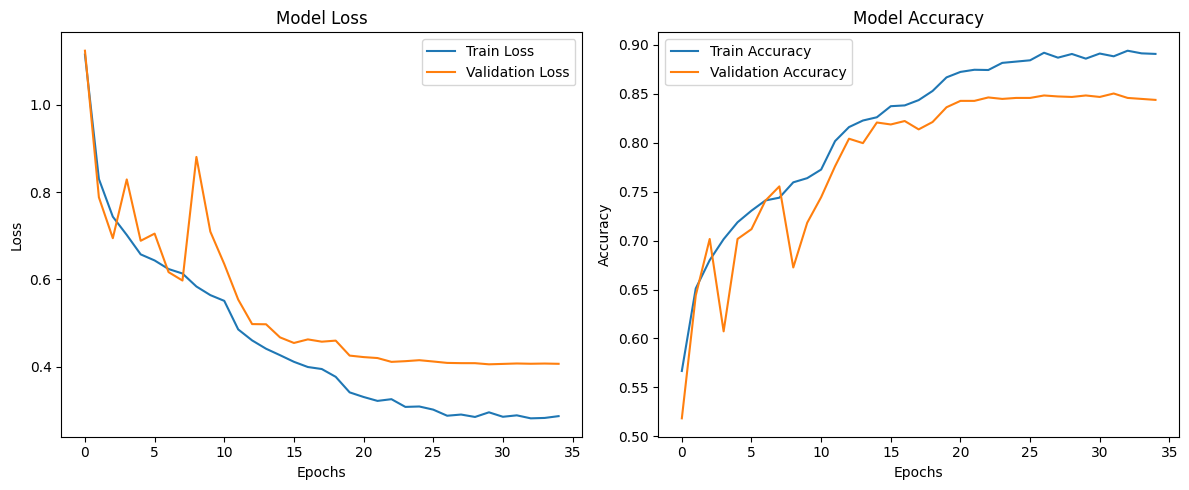

epoch/accuracy,▁▃▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,███████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▃▅▅▆▆▄▅▆▆▇▇▇▇▇▇▇████████████████
epoch/val_loss,█▅▄▅▄▄▃▃▆▄▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.89079
epoch/epoch,34
epoch/learning_rate,0.0
epoch/loss,0.28686
epoch/val_accuracy,0.8438


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import wandb
from wandb.integration.keras import WandbModelCheckpoint, WandbMetricsLogger

# Inicializácia W&B
wandb.init(
    project="age-detection",
    config={
        "model_name": "Custom_CNN",
        "input_shape": (224, 224, 3),
        "num_classes": 3,
        "learning_rate": 0.001,
        "batch_size": BATCH_SIZE,
        "epochs": 50,
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
)

config = wandb.config

def create_custom_cnn(input_shape, num_classes):
    model = Sequential([
        # Prvý konvolučný blok
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Druhý konvolučný blok
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Tretí konvolučný blok
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Flatten a Dense vrstvy
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Vytvorenie modelu
model = create_custom_cnn(
    input_shape=config.input_shape,
    num_classes=config.num_classes
)

# Kompilácia modelu
model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=config.loss,
    metrics=config.metrics
)

# Callbacky
callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    WandbModelCheckpoint(filepath="models/Custom_CNN.keras", save_best_only=True, monitor="val_loss", verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# Tréning modelu
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    callbacks=callbacks
)

print('\n')
# Evaluácia na validačnej množine
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

print('\n')
# Evaluácia na testovacej množine
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Vizualizácia výsledkov
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

wandb.finish()

### Predikcia modelu custom CNN

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

      MIDDLE       0.84      0.82      0.83        33
         OLD       0.67      0.80      0.73         5
       YOUNG       0.85      0.85      0.85        26

    accuracy                           0.83        64
   macro avg       0.79      0.82      0.80        64
weighted avg       0.83      0.83      0.83        64

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8390 - loss: 0.4146
Test Loss: 0.4134, Test Accuracy: 0.8368


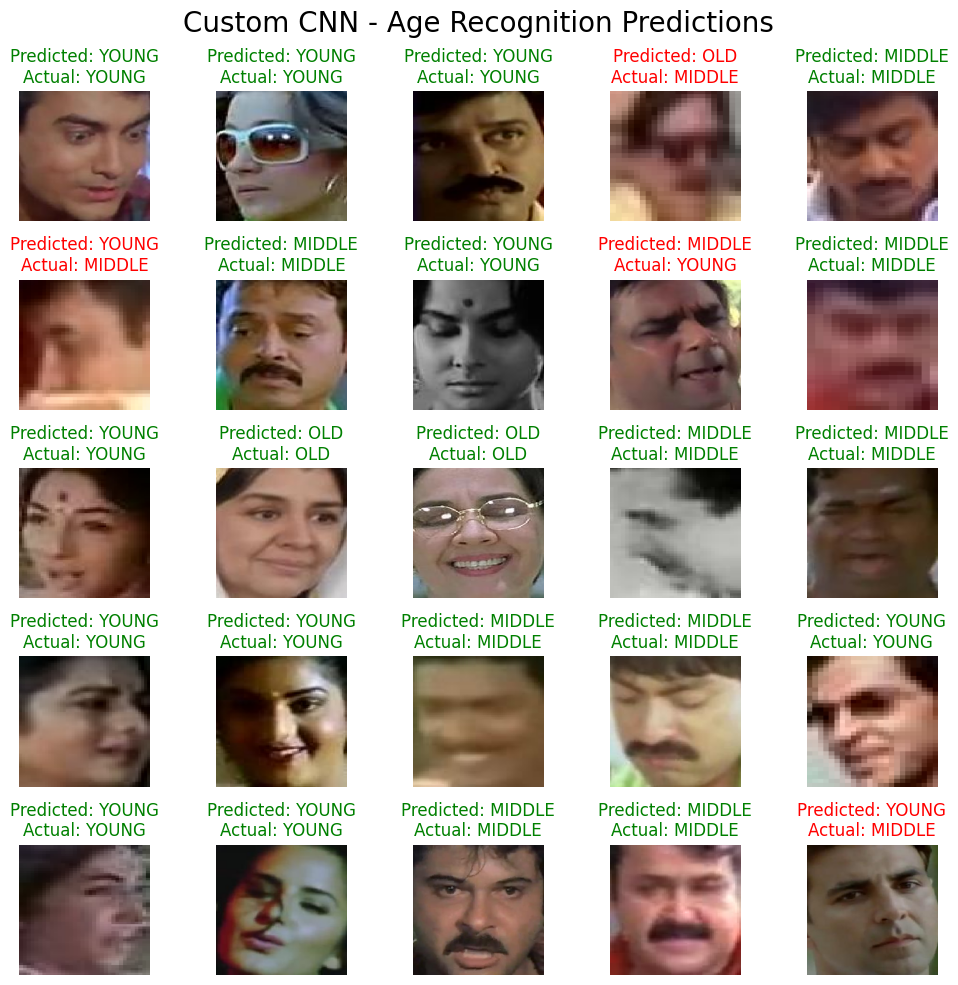

In [ ]:
from sklearn.metrics import classification_report

test_images, test_labels = next(test_gen)  # Získa jednu dávku obrázkov z test generátora

# Predikcia
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

class_labels = list(test_gen.class_indices.keys())

# Vygenerovanie klasifikačnej správy
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print("Classification Report:")
print(report)

# Hodnotenie na testovacej množine
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Enkódnutie tried do čitatelnej podoby
label_encoder = LabelEncoder()
label_encoder.fit(train_df['Class'])
class_names = label_encoder.classes_

# Zobrazenie 5x5 => 25 obrázkov s predikovanými a realnymmi hodnotami
plt.figure(figsize=(10, 10))
plt.suptitle("Custom CNN - Age Recognition Predictions", fontsize=20)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(
        f"Predicted: {class_names[predicted_labels[i]]}\n"
        f"Actual: {class_names[true_labels[i]]}",
        color="green" if predicted_labels[i] == true_labels[i] else "red"
    )

plt.tight_layout()
plt.show()

### Vytvorenie modelu Xception - Pretrained

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.4621 - loss: 6.2729
Epoch 1: val_loss improved from inf to 2.29598, saving model to models/Custom-CNN-Xception.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 247s 765ms/step - accuracy: 0.4624 - loss: 6.2668 - val_accuracy: 0.7197 - val_loss: 2.2960
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.6985 - loss: 1.7965
Epoch 2: val_loss improved from 2.29598 to 1.01927, saving model to models/Custom-CNN-Xception.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 164s 640ms/step - accuracy: 0.6986 - loss: 1.7952 - val_accuracy: 0.7519 - val_loss: 1.0193
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7759 - loss: 0.8533
Epoch 3: val_loss improved from 1.01927 to 0.84331, saving model to models/Custom-CNN-Xception.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 164s 641ms/step - accuracy: 0.7759 - loss: 0.8530 - val_accuracy: 0.7223 - val_loss: 0.8433
Epoch 4/20
249/249 ━━━━

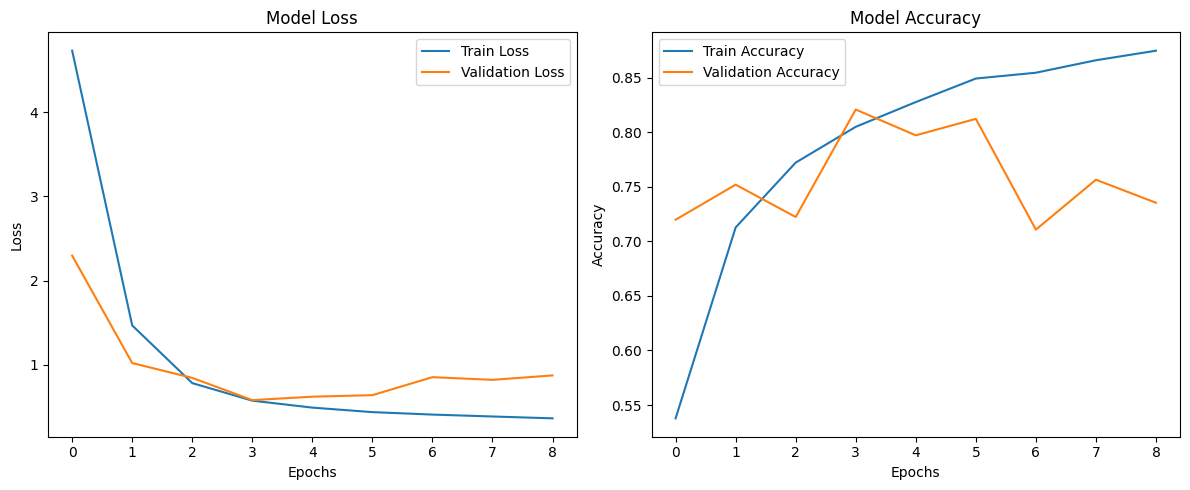

epoch/accuracy,▁▅▆▇▇▇███
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▁▁
epoch/val_accuracy,▂▄▂█▆▇▁▄▃
epoch/val_loss,█▃▂▁▁▁▂▂▂
epoch/accuracy,0.87459
epoch/epoch,8
epoch/learning_rate,0.001
epoch/loss,0.36261
epoch/val_accuracy,0.73531


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import wandb
from wandb.integration.keras import WandbModelCheckpoint, WandbMetricsLogger
from sklearn.utils.class_weight import compute_class_weight

# Initialize W&B
wandb.init(
    project="age-detection",
    config={
        "model_name": "Custom-CNN-Xception",
        "input_shape": (224, 224, 3),
        "num_classes": 3,
        "dropout_rate": 0.5,
        "dense_units": 256,
        "learning_rate": 1e-3,
        "batch_size": BATCH_SIZE,
        "epochs": 20,
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
)

config = wandb.config

# Define Xception Model
def create_xception(input_shape, num_classes, dropout_rate, dense_units):
    # Load Xception as base model
    base_model = Xception(weights="imagenet", include_top=False, input_shape=input_shape)

    model = Sequential([
        base_model,
        # Pooling layer
        GlobalAveragePooling2D(),
        BatchNormalization(),
        # Fully connected layer
        Dense(dense_units, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-2)),
        BatchNormalization(),
        # Dropout for regularization
        Dropout(dropout_rate),
        # Fully connected layer
        Dense(dense_units // 2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-2)),
        BatchNormalization(),
        # Additional dropout
        Dropout(dropout_rate),
        # Output layer for classification
        Dense(num_classes, activation="softmax")
    ])
    return model

# Create the model
model = create_xception(
    input_shape=config.input_shape,
    num_classes=config.num_classes,
    dropout_rate=config.dropout_rate,
    dense_units=config.dense_units
)

# Compile the model
model.compile(
    optimizer=config.optimizer,
    loss=config.loss,
    metrics=config.metrics
)

# Callbacks
callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    WandbModelCheckpoint(filepath="models/Custom-CNN-Xception.keras", save_best_only=True, monitor="val_loss", verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True, verbose=1)
]

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["Class_encoded"]),
    y=train_df["Class_encoded"]
)

class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

print('\n')
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

print('\n')
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

wandb.finish()

### Predikcia modelu Xception

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Classification Report:
              precision    recall  f1-score   support

      MIDDLE       0.81      0.76      0.78        33
         OLD       0.80      0.80      0.80         5
       YOUNG       0.71      0.77      0.74        26

    accuracy                           0.77        64
   macro avg       0.77      0.78      0.77        64
weighted avg       0.77      0.77      0.77        64

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8160 - loss: 0.5825
Test Loss: 0.5737, Test Accuracy: 0.8222


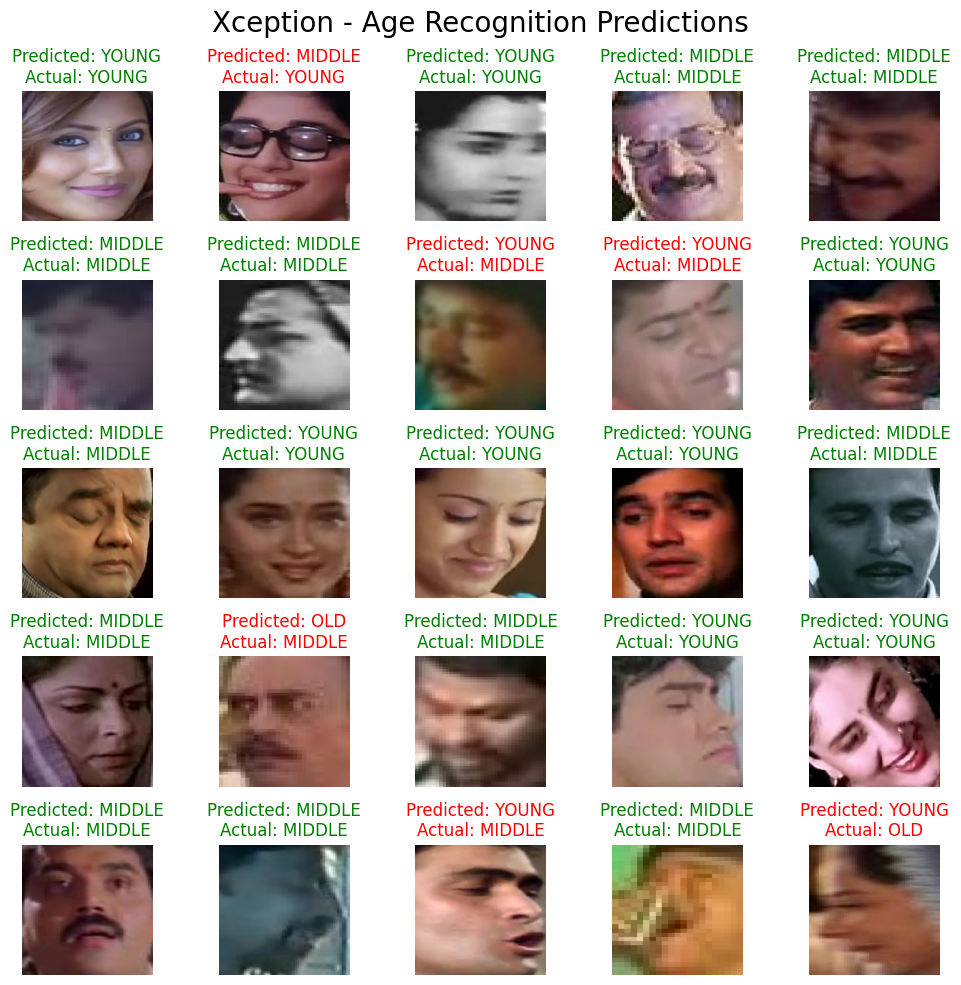

In [ ]:
from sklearn.metrics import classification_report

test_images, test_labels = next(test_gen)  # Získa jednu dávku obrázkov z test generátora

# Predikcia
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

class_labels = list(test_gen.class_indices.keys())

# Vygenerovanie klasifikačnej správy
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print("Classification Report:")
print(report)

# Hodnotenie na testovacej množine
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Enkódnutie tried do čitatelnej podoby
label_encoder = LabelEncoder()
label_encoder.fit(train_df['Class'])
class_names = label_encoder.classes_

# Zobrazenie 5x5 => 25 obrázkov s predikovanými a realnymmi hodnotami
plt.figure(figsize=(10, 10))
plt.suptitle("Xception - Age Recognition Predictions", fontsize=20)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(
        f"Predicted: {class_names[predicted_labels[i]]}\n"
        f"Actual: {class_names[true_labels[i]]}",
        color="green" if predicted_labels[i] == true_labels[i] else "red"
    )

plt.tight_layout()
plt.show()

### Vytvorenie modelu ResNet50 - Pretrained

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.4319 - loss: 1.5032
Epoch 1: val_loss improved from inf to 1.56989, saving model to models/Custom-CNN-ResNet50.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 231s 740ms/step - accuracy: 0.4320 - loss: 1.5022 - val_accuracy: 0.1205 - val_loss: 1.5699 - learning_rate: 0.0010
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.5876 - loss: 0.8240
Epoch 2: val_loss did not improve from 1.56989
249/249 ━━━━━━━━━━━━━━━━━━━━ 162s 632ms/step - accuracy: 0.5877 - loss: 0.8238 - val_accuracy: 0.1205 - val_loss: 2.0772 - learning_rate: 0.0010
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.6833 - loss: 0.6476
Epoch 3: val_loss did not improve from 1.56989
249/249 ━━━━━━━━━━━━━━━━━━━━ 162s 634ms/step - accuracy: 0.6833 - loss: 0.6475 - val_accuracy: 0.1321 - val_loss: 1.9896 - learning_rate: 0.0010
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - acc

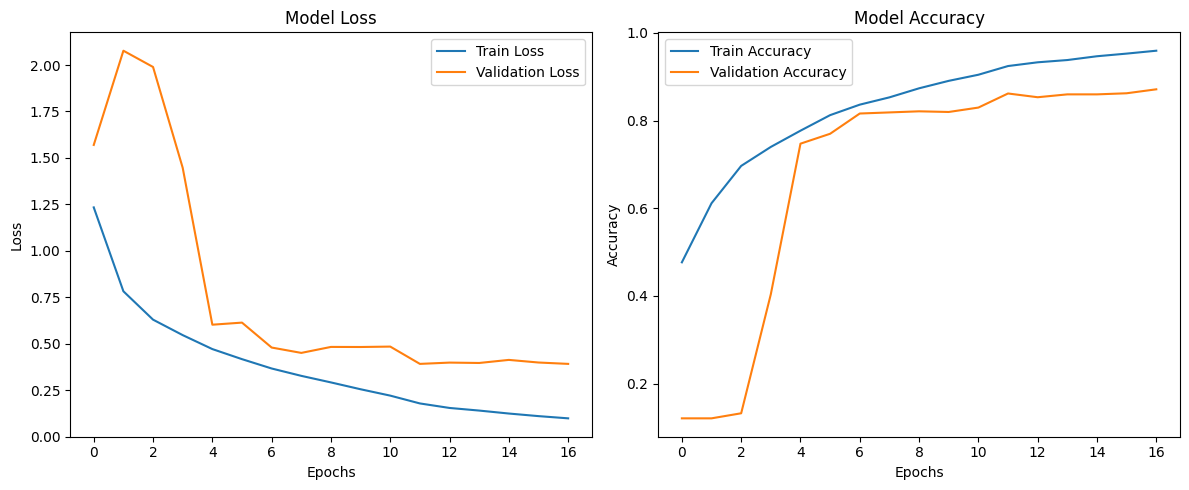

epoch/accuracy,▁▃▄▅▅▆▆▆▇▇▇▇█████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,███████████▃▃▃▃▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▄▇▇▇██████████
epoch/val_loss,▆██▅▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.9595
epoch/epoch,16
epoch/learning_rate,0.00025
epoch/loss,0.0982
epoch/val_accuracy,0.87142


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import wandb
from wandb.integration.keras import WandbModelCheckpoint, WandbMetricsLogger

from sklearn.utils.class_weight import compute_class_weight

# Inicializácia W&B pre logovanie
wandb.init(
    project="age-detection",
    config={
        "model_name": "Custom-CNN-ResNet50",
        "input_shape": (224, 224, 3),
        "num_classes": 3,
        "dropout_rate": 0.5,
        "dense_units": 256,
        "learning_rate": 1e-3,
        "batch_size": BATCH_SIZE,
        "epochs": 20,
        "optimizer": "SGD",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
)

config = wandb.config

# Definícia modelu ResNet50
def create_resnet50(input_shape, num_classes, dropout_rate, dense_units):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

    model = Sequential([
        base_model,
        # Priemerovanie výstupu
        GlobalAveragePooling2D(),
        BatchNormalization(),
        # Pridaná plne spojená vrstva
        Dense(dense_units, activation="relu"),
        BatchNormalization(),
        # Regularizácia
        Dropout(dropout_rate),
        # Pridaná plne spojená vrstva
        Dense(dense_units // 2, activation="relu"),
        BatchNormalization(),
        # Regularizácia
        Dropout(dropout_rate),
        # Výstupná vrstva pre klasifikáciu
        Dense(num_classes, activation="softmax")
    ])
    return model

# Vytvorenie modelu
model = create_resnet50(
    input_shape=config.input_shape,
    num_classes=config.num_classes,
    dropout_rate=config.dropout_rate,
    dense_units=config.dense_units
)

# Kompilácia modelu
model.compile(
    optimizer=SGD(learning_rate=config.learning_rate, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacky pre tréning
callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    WandbModelCheckpoint(filepath="models/Custom-CNN-ResNet50.keras", save_best_only=True, monitor="val_loss", verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True, verbose=1)
]

# Vypočet vah tried
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["Class_encoded"]),
    y=train_df["Class_encoded"]
)
class_weights = dict(enumerate(class_weights))

# Tréning modelu
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

print('\n')
# Hodnotenie na validačnej množine
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

print('\n')
# Hodnotenie na testovacej množine
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Zobrazenie grafov tréningu
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

wandb.finish()

### Predikacia modelu ResNet50

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Classification Report:
              precision    recall  f1-score   support

      MIDDLE       0.89      0.86      0.88        37
         OLD       0.88      0.88      0.88         8
       YOUNG       0.80      0.84      0.82        19

    accuracy                           0.86        64
   macro avg       0.85      0.86      0.86        64
weighted avg       0.86      0.86      0.86        64

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8699 - loss: 0.3868
Test Loss: 0.3855, Test Accuracy: 0.8724


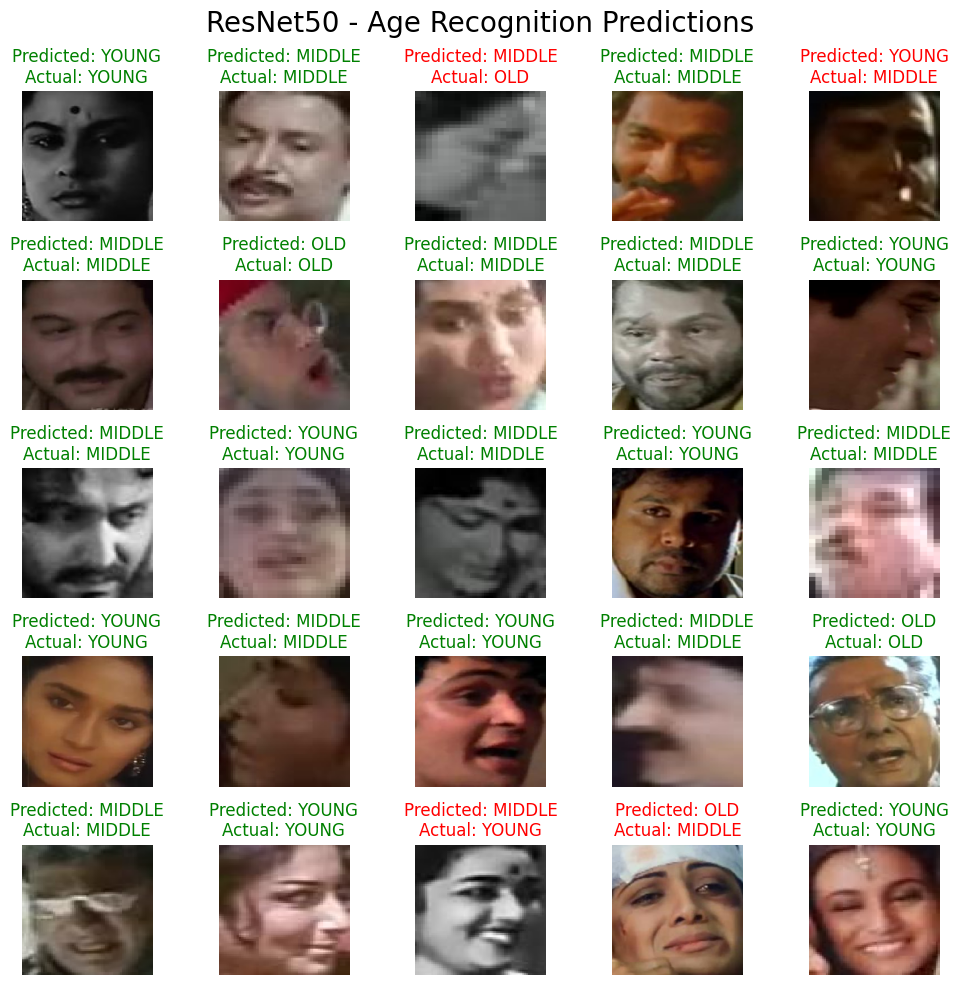

In [ ]:
from sklearn.metrics import classification_report

test_images, test_labels = next(test_gen)  # Získa jednu dávku obrázkov z test generátora

# Predikcia
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

class_labels = list(test_gen.class_indices.keys())

# Vygenerovanie klasifikačnej správy
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print("Classification Report:")
print(report)

# Hodnotenie na testovacej množine
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Enkódnutie tried do čitatelnej podoby
label_encoder = LabelEncoder()
label_encoder.fit(train_df['Class'])
class_names = label_encoder.classes_

# Zobrazenie 5x5 => 25 obrázkov s predikovanými a realnymmi hodnotami
plt.figure(figsize=(10, 10))
plt.suptitle("ResNet50 - Age Recognition Predictions", fontsize=20)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(
        f"Predicted: {class_names[predicted_labels[i]]}\n"
        f"Actual: {class_names[true_labels[i]]}",
        color="green" if predicted_labels[i] == true_labels[i] else "red"
    )

plt.tight_layout()
plt.show()

## 4.2.B

### ResNet50 - Najlepšie výsledky

- Dosiahol najvyššiu celkovú presnosť: 87.24%
- Najnižšiu stratu (loss): 0.3855
- Vyrovnané výsledky naprieč všetkými triedami:
<br><br>
- MIDDLE: F1-skóre 0.88
- OLD: F1-skóre 0.88
- YOUNG: F1-skóre 0.82
<br><br>
- Najvyššia presnosť u triedy MIDDLE (0.89)

### Custom CNN - Druhé najlepšie výsledky

- Celková presnosť: 83.6%
- Strata: 0.4134
- Najlepšie výsledky v klasifikácii YOUNG triedy:
<br><br>
- YOUNG: F1-skóre 0.85
- MIDDLE: F1-skóre 0.83
- OLD: F1-skóre 0.73
<br><br>
- Nižšia presnosť pri triede OLD (0.67)

### Xception - Najslabšie výsledky

- Najnižšia celková presnosť: 82.22%
- Najvyššia strata: 0.5737
- Najnižšie F1-skóre vo všetkých kategóriách:
<br><br>
- MIDDLE: F1-skóre 0.78
- OLD: F1-skóre 0.80
- YOUNG: F1-skóre 0.74


### Celkové zhodnotenie

- ResNet50 sa ukázal ako najvhodnejší model pre túto úlohu, s najvyššou presnosťou a najnižšou stratou, poskytujúc konzistentné výsledky naprieč všetkými vekovými kategóriami.
- Custom CNN prekvapivo prekonala Xception, čo naznačuje, že jednoduchšia, ale cielenejšie navrhnutá architektúra môže byť efektívnejšia než komplexnejší model.
- Všetky modely mali určité problémy s klasifikáciou triedy OLD, čo môže byť spôsobené menším počtom vzoriek v testovacej sade.
- Z pohľadu pomeru výkon/komplexnosť sa Custom CNN javí ako dobrý kompromis, keďže dosahuje solídne výsledky s jednoduchšou architektúrou.